In [1]:
import torch
torch.set_default_dtype(torch.float64)
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving test_series.npy to test_series.npy
Saving train_series.npy to train_series.npy


{'test_series.npy': b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<f8\', \'fortran_order\': False, \'shape\': (3991, 5, 2), }                                                    \n\x08,\x1a\xf5m\xa9\'@\xf28q$\x03\xb2\x1c@\xa3\xb2.\x19\xa6\xcb#@\xc5\xf9l\x08\xf6[\x1b@\xbe\xae]\xf6\xf6H!@\xb5/\xed{o\xba\x1c@T\xacW\xc5\xb3\x8d\x1f@.\xa5\x10ek\x85#@\xa5t.\x9a\x9c\xe3 @\x96Y[\x0c6^ @\xa3\xb2.\x19\xa6\xcb#@\xc5\xf9l\x08\xf6[\x1b@\xbe\xae]\xf6\xf6H!@\xb5/\xed{o\xba\x1c@T\xacW\xc5\xb3\x8d\x1f@.\xa5\x10ek\x85#@\xa5t.\x9a\x9c\xe3 @\x96Y[\x0c6^ @\xf28q$\x03\xb2\x1c@\x8e(\xd9<\xf9\x8a\x1e@\xbe\xae]\xf6\xf6H!@\xb5/\xed{o\xba\x1c@T\xacW\xc5\xb3\x8d\x1f@.\xa5\x10ek\x85#@\xa5t.\x9a\x9c\xe3 @\x96Y[\x0c6^ @\xf28q$\x03\xb2\x1c@\x8e(\xd9<\xf9\x8a\x1e@\xc5\xf9l\x08\xf6[\x1b@\x10\xcf\x8a \x97\xfb\x1e@T\xacW\xc5\xb3\x8d\x1f@.\xa5\x10ek\x85#@\xa5t.\x9a\x9c\xe3 @\x96Y[\x0c6^ @\xf28q$\x03\xb2\x1c@\x8e(\xd9<\xf9\x8a\x1e@\xc5\xf9l\x08\xf6[\x1b@\x10\xcf\x8a \x97\xfb\x1e@\xb5/\xed{o\xba\x1c@&w4\xa2\x15F!@\xa5t.\x9a\x9c\xe3 

In [4]:
train = np.load('train_series.npy')
test = np.load('test_series.npy')

In [5]:
train.shape

(15991, 5, 2)

In [6]:
train[:5]

array([[[ 8.5       , 11.42585959],
        [ 8.15121745, 11.36895826],
        [ 9.88256224, 13.23515265],
        [10.67993937, 13.45132121],
        [11.36971828, 12.34151872]],

       [[ 8.15121745, 11.36895826],
        [ 9.88256224, 13.23515265],
        [10.67993937, 13.45132121],
        [11.36971828, 12.34151872],
        [11.42585959, 14.82885045]],

       [[ 9.88256224, 13.23515265],
        [10.67993937, 13.45132121],
        [11.36971828, 12.34151872],
        [11.42585959, 14.82885045],
        [11.36895826, 15.12173746]],

       [[10.67993937, 13.45132121],
        [11.36971828, 12.34151872],
        [11.42585959, 14.82885045],
        [11.36895826, 15.12173746],
        [13.23515265, 15.46706368]],

       [[11.36971828, 12.34151872],
        [11.42585959, 14.82885045],
        [11.36895826, 15.12173746],
        [13.23515265, 15.46706368],
        [13.45132121, 15.14498818]]])

In [7]:
np.random.shuffle(train)

In [8]:
train[:5]

array([[[  3.55328699,   2.69952538],
        [  4.92960208,   2.68922239],
        [  4.70163005,   1.82719146],
        [  3.35888611,   0.71632853],
        [  3.73147019,   2.00911002]],

       [[ 13.12639971,  15.77682695],
        [ 12.97633924,  15.38473805],
        [ 13.62587782,  14.75963868],
        [ 14.49993999,  14.83786551],
        [ 15.88665269,  12.01181776]],

       [[ -0.799503  ,  -1.9408248 ],
        [ -0.53871096,  -3.09704949],
        [  0.25197908,  -2.67601141],
        [  0.09169716,  -1.86156776],
        [ -2.24722984,  -2.1742801 ]],

       [[ -0.93921097,   0.68281803],
        [ -0.34492625,   2.3746601 ],
        [  0.82275138,   0.52065308],
        [  1.64694072,   0.02767283],
        [  1.61466107,   0.08715498]],

       [[-14.63883584, -17.97851398],
        [-13.97746217, -17.47337193],
        [-13.8635592 , -16.52848919],
        [-14.42651531, -14.53489599],
        [-16.42594847, -14.71293604]]])

In [9]:
train[:,:,0].size

79955

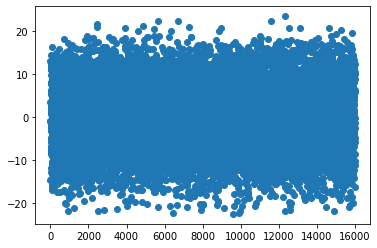

In [10]:
plt.scatter(range(len(train)),train[:,0,0])

In [11]:
if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'

In [12]:
device

'cuda:0'

In [436]:
# Hyperparameters
valid_size = 0.2
learning_rate = 1e-3
epochs = 500
batch_size = 64
wd = 1e-7

In [437]:
split = int(np.floor(valid_size * len(train)))
train_dataset=train[:-split]
valid_dataset=train[-split:]

In [438]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [413]:
def initialization(m):
  if type(m) == torch.nn.Linear:
    torch.nn.init.kaiming_normal_(m.weight)
    m.bias.data.fill_(0.01)

In [414]:
class My_Model(torch.nn.Module):

  def __init__(self):
    super(My_Model, self).__init__()

    # define parameters
    input_size = 1
    hidden_size = 9
    num_layers = 1
    batch_first = True
    
    #self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first)
    self.enc = torch.nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first)
    self.dec = torch.nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first)
    self.fc = torch.nn.Linear(hidden_size, input_size)

  def forward(self, x):    
    # Propagate input through LSTM
    #out, hidden = self.lstm(x)    
    out, hidden = self.enc(x)    
    out = torch.nn.functional.relu(out)
    out, hidden = self.dec(out, hidden)
    out = self.fc(out)    
    return out

In [415]:
def mape_loss(input, target):
    return torch.sum(torch.abs(input - target) / torch.abs(target))

In [439]:
model = My_Model()
model.apply(initialization)
loss_fn = mape_loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
model = model.to(device)
params = list(model.parameters())
print("The number of parameters:", sum([p.numel() for p in model.parameters() if p.requires_grad]), "elements")

The number of parameters: 874 elements


In [440]:
loss_list = [] # avg loss for total epoch
best_acc = None
early_stop_counter = 0
epoch = 0 # save last epoch
# Train
for epoch in range(epochs):
  running_loss = [] # loss for one epoch
  model.train()
  for i, batch in enumerate(train_loader):
    x = batch[:,:,0].to(device)
    y = batch[:,:,1].to(device)
    # Forward pass: Compute predicted y by passing x to the model     
    y_pred = model(x.reshape(-1,5,1)).reshape(-1,5)       
    # Compute and print loss
    loss = loss_fn(y_pred, y)
    running_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  # Save Training loss of each epoch
  avg_loss = sum(running_loss) / len(running_loss)  
  print("epoch: {} loss: {:.3f}".format(epoch+1, avg_loss), end=" ")
  loss_list.append(avg_loss)
  
  # Validation
  model.eval()
  with torch.no_grad():
    valid_accuracy = [] # loss of validation set
    for data in valid_loader:
      valid_x = data[:,:,0].to(device)
      valid_y = data[:,:,1]
      valid_y_pred = model(valid_x.reshape(-1,5,1)).reshape(-1,5).to("cpu")
      mape = np.mean((np.fabs(np.subtract(valid_y, valid_y_pred) / valid_y)).detach().numpy())         
      valid_accuracy.append(mape)      
    # Save minimum validation loss model
    val_acc = sum(valid_accuracy) / len(valid_accuracy)
    print("validation accuracy: {:.3f}".format(val_acc))    
    if not best_acc or val_acc < best_acc:
      torch.save(model.state_dict(), './best.pt')
      best_acc = val_acc
      early_stop_counter = 0
    else: # No evolution
      early_stop_counter += 1
      if early_stop_counter % 10 == 5:
        scheduler.step()
  if early_stop_counter == 50: # early stop
    break

epoch: 1 loss: 320.942 validation accuracy: 0.982
epoch: 2 loss: 315.723 validation accuracy: 0.958
epoch: 3 loss: 307.172 validation accuracy: 0.936
epoch: 4 loss: 303.170 validation accuracy: 0.923
epoch: 5 loss: 298.563 validation accuracy: 0.910
epoch: 6 loss: 293.388 validation accuracy: 0.896
epoch: 7 loss: 290.857 validation accuracy: 0.887
epoch: 8 loss: 289.603 validation accuracy: 0.873
epoch: 9 loss: 280.313 validation accuracy: 0.866
epoch: 10 loss: 279.078 validation accuracy: 0.849
epoch: 11 loss: 274.424 validation accuracy: 0.842
epoch: 12 loss: 273.207 validation accuracy: 0.827
epoch: 13 loss: 268.943 validation accuracy: 0.820
epoch: 14 loss: 268.729 validation accuracy: 0.816
epoch: 15 loss: 264.571 validation accuracy: 0.800
epoch: 16 loss: 259.453 validation accuracy: 0.789
epoch: 17 loss: 257.397 validation accuracy: 0.780
epoch: 18 loss: 258.233 validation accuracy: 0.775
epoch: 19 loss: 254.011 validation accuracy: 0.765
epoch: 20 loss: 252.623 validation accur

In [441]:
print(learning_rate)
print(scheduler.get_last_lr()[0])

0.001
0.0008429431933839266


MAPE: 0.49309514422389533


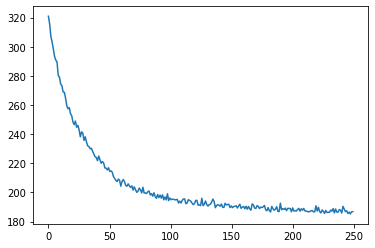

In [442]:
# Test
model.load_state_dict(torch.load('./best.pt'))
model = model.to("cpu")
y_pred = model(torch.from_numpy(test[:,:,0]).reshape(-1,5,1)).reshape(-1,5)
mape = np.mean((np.fabs(np.subtract(test[:,:,1], y_pred.detach().numpy()) / test[:,:,1])))
print("MAPE:",mape)
#print("Weighted F1:", f1_score(test[:,:,1], yp, average='weighted'))

step = np.linspace(0, epoch+1, epoch+1)
plt.plot(step, np.array(loss_list))